# <center> EEG Classification Using CNN on Images</center>
**<center>Predicting whether a student understood a video based on their EEG signals</center>**

*Author: Shiven Taneja*

*Date: 26th August 2023*

[Github Repository](http://) (TO BE UPDATED!!)

# 1. Project Overview

I have been completing the [Practical Deep Learning For Coders](https://course.fast.ai/) course by [Fast.AI](https://fast.ai). In the first two lessons, we learn about using the fastai library to classify images to a category through CNN. The example they used was classifying dogs vs. cats but on their forum there was a discussion on classifying time series data by creating images and using a CNN classifier on that. One person used this to classify [olive oils by means of a polar coordinate transformation called the Gramian Angular Field](https://forums.fast.ai/t/share-your-work-here/27676/366). This had an accuracy of 93.3%.

This inspired me to try the same technique on EEG classification. In order to do this, I used the EEG dataset [EEG data / Distance Learning ](https://www.kaggle.com/datasets/madyanomar/eeg-data-distance-learning-environment). The data from that dataset was taken using the [Emotiv Epox X ](https://www.emotiv.com/epoc-x/)14 channel headset. The data tracked the brainwaves of participants as they watched a video and classified them as either understanding or not understanding the content. In order ot classify this data, I transformed this data into a MNE data format and then created an image of it using the ssqueezepy imshow function. I saved these files and used a CNN to classify the images. During training, **my model worked with an accuracy of 80-90%**. 

# 2. Setting up the enviornment + Data Manipulation
## 2.1 Data import 

In [1]:
%%capture
!pip install ssqueezepy
! pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
import mne
import numpy as np
from fastai import *
from fastai.imports import *
from fastai.vision import *
from fastai.vision.all import *

In [3]:
main_path = '/kaggle/input/eeg-data-distance-learning-environment'

## 2.2 Understanding the data

From this dataframe, we can see that the first two columns represent the video ID and the subject ID. Columns 3-16 contain the raw EEG data from the EEG sensors while columns 17-86 contain the 5 brain waves (Alpha, Beta Low, Beta High, Gamma, Theta) for each channel. The last column contains the classifier with 0 being the participant did not understand the video while 1 being that the participant did understand the video.

In [4]:
df = pd.read_csv(os.path.join(main_path, 'EEG_data.csv'))
df

,video_id,subject_id,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4,POW.AF3.Theta,POW.AF3.Alpha,POW.AF3.BetaL,POW.AF3.BetaH,POW.AF3.Gamma,POW.F7.Theta,POW.F7.Alpha,POW.F7.BetaL,POW.F7.BetaH,POW.F7.Gamma,POW.F3.Theta,POW.F3.Alpha,POW.F3.BetaL,POW.F3.BetaH,POW.F3.Gamma,POW.FC5.Theta,POW.FC5.Alpha,POW.FC5.BetaL,POW.FC5.BetaH,POW.FC5.Gamma,POW.T7.Theta,POW.T7.Alpha,POW.T7.BetaL,POW.T7.BetaH,POW.T7.Gamma,POW.P7.Theta,POW.P7.Alpha,POW.P7.BetaL,POW.P7.BetaH,POW.P7.Gamma,POW.O1.Theta,POW.O1.Alpha,POW.O1.BetaL,POW.O1.BetaH,POW.O1.Gamma,POW.O2.Theta,POW.O2.Alpha,POW.O2.BetaL,POW.O2.BetaH,POW.O2.Gamma,POW.P8.Theta,POW.P8.Alpha,POW.P8.BetaL,POW.P8.BetaH,POW.P8.Gamma,POW.T8.Theta,POW.T8.Alpha,POW.T8.BetaL,POW.T8.BetaH,POW.T8.Gamma,POW.FC6.Theta,POW.FC6.Alpha,POW.FC6.BetaL,POW.FC6.BetaH,POW.FC6.Gamma,POW.F4.Theta,POW.F4.Alpha,POW.F4.BetaL,POW.F4.BetaH,POW.F4.Gamma,POW.F8.Theta,POW.F8.Alpha,POW.F8.BetaL,POW.F8.BetaH,POW.F8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma,subject_understood
0,0,0,4210.641113,4179.102539,4287.948730,4235.384766,4207.948730,4165.000000,4135.897461,4170.000000,4155.384766,4157.179688,4610.384766,4388.846191,4413.461426,4499.743652,1.859064,1.488007,0.294396,0.459987,0.188314,1.779598,0.620659,0.497043,0.344509,0.178338,1.840744,1.740009,0.369845,0.484037,0.187594,1.842673,0.856627,0.474424,0.415397,0.175614,0.584676,1.208085,0.214748,0.144198,0.120753,1.297408,0.761949,0.354184,0.166404,0.099637,1.422160,0.889572,0.552382,0.149173,0.136558,2.078273,1.472955,1.057647,0.280043,0.153327,1.409152,0.979982,0.869081,0.417896,0.188206,1.428878,0.877251,0.553363,0.383072,0.112488,2.348271,1.782157,0.644852,0.520060,0.154410,2.349918,2.376053,0.655009,0.613906,1.120513,3.758370,1.583895,0.504567,0.471979,0.138717,1.801014,1.504794,0.258570,0.435745,0.469483,0
1,0,0,4201.025879,4188.717773,4280.128418,4236.922852,4209.615234,4152.436035,4130.128418,4149.487305,4149.487305,4157.820313,4583.717773,4376.666504,4392.820313,4488.461426,2.030504,1.509949,0.496135,0.452138,0.194018,1.821380,0.596975,0.685146,0.319841,0.174923,1.941082,1.797096,0.558355,0.485693,0.189281,1.945797,0.943827,0.654867,0.437179,0.175975,0.641788,1.284735,0.212188,0.161631,0.120083,1.522173,0.821546,0.295174,0.191005,0.110549,1.635566,0.813352,0.416753,0.149681,0.127509,2.409505,1.458509,1.079635,0.326943,0.152629,1.462499,0.907250,0.969058,0.482167,0.192056,1.761167,0.858840,0.714015,0.438183,0.102417,2.969623,1.850320,0.841046,0.601471,0.139706,2.478265,2.495719,0.745543,0.663186,1.769841,4.580270,1.709560,0.606587,0.527616,0.155580,1.859177,1.379617,0.317579,0.468416,0.642560,0
2,0,0,4203.205078,4182.820313,4282.820313,4231.025879,4207.820313,4172.436035,4131.538574,4147.948730,4131.666504,4131.666504,4574.743652,4377.051270,4390.512695,4483.077148,2.315652,1.541873,0.812744,0.455024,0.193780,1.897375,0.612869,0.982626,0.304586,0.164330,2.164562,1.862794,0.852138,0.483437,0.184689,2.115402,1.042002,0.946591,0.449115,0.172039,0.705399,1.248802,0.220355,0.173320,0.116159,1.822336,0.855601,0.262621,0.212594,0.118272,1.789751,0.748843,0.348561,0.153822,0.115047,2.633745,1.418934,1.177704,0.363531,0.152218,1.576797,0.863319,1.054493,0.520667,0.193345,2.099791,0.900051,0.864675,0.452751,0.094539,3.570862,1.931157,1.099680,0.659150,0.131624,2.612426,2.580640,0.909882,0.681112,2.377539,5.230789,1.873591,0.795834,0.565414,0.170816,2.027946,1.283876,0.441925,0.494701,0.798197,0
3,0,0,4186.538574,4168.717773,4266.794922,4229.230957,4202.179688,4155.384766,4128.333496,4151.666504,4136.666504,4134.230957,4565.512695,4362.436035,4380.897461,4471.025879,2.713728,1.648073,1.184512,0.466466,0.189903,2.000522,0.716119,1.314321,0.311415,0.150169,2.531722,1.999752,1.189854,0.474792,0.176145,2.327959,1.185726,1.291802,0.455347,0.166402,0.761616,1.111277,0.243083,0.176220,0.110383,2.241397,0.836288,0.256094,0.225850,0.121525,1.868363,0.700736,0.350339,0.160516,0.101635,2.665952,1.371016,1.2

We do not need the data from columns 17-86 so we can remove those. We can also remove EEG. in the column names for rows 3-16. 

In [5]:
cols_remove=df.columns.tolist()[16:-1]
df=df.loc[:, ~df.columns.isin(cols_remove)]
df.columns = df.columns.str.strip('EEG.')
df

,video_id,subject_id,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,subject_understood
0,0,0,4210.641113,4179.102539,4287.948730,4235.384766,4207.948730,4165.000000,4135.897461,4170.000000,4155.384766,4157.179688,4610.384766,4388.846191,4413.461426,4499.743652,0
1,0,0,4201.025879,4188.717773,4280.128418,4236.922852,4209.615234,4152.436035,4130.128418,4149.487305,4149.487305,4157.820313,4583.717773,4376.666504,4392.820313,4488.461426,0
2,0,0,4203.205078,4182.820313,4282.820313,4231.025879,4207.820313,4172.436035,4131.538574,4147.948730,4131.666504,4131.666504,4574.743652,4377.051270,4390.512695,4483.077148,0
3,0,0,4186.538574,4168.717773,4266.794922,4229.230957,4202.179688,4155.384766,4128.333496,4151.666504,4136.666504,4134.230957,4565.512695,4362.436035,4380.897461,4471.025879,0
4,0,0,4232.436035,4216.922852,4306.922852,4270.769043,4217.436035,4166.538574,4155.897461,4162.820313,4143.461426,4154.487305,4612.436035,4403.333496,4410.641113,4512.179688,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68826,10,7,4353.846191,4349.487305,4317.563965,4343.461426,4375.641113,4296.025879,4351.666504,4309.358887,4287.436035,4253.589844,4410.128418,4404.871582,4334.871582,4389.615234,1
68827,10,7,4335.769043,4326.538574,4310.641113,4331.153809,4363.333496,4297.179688,4336.025879,4282.563965,4276.410156,4260.641113,4415.641113,4395.897461,4342.948730,4391.794922,1
68828,10,7,4321.666504,4313.205078,4310.000000,4310.384766,4357.436035,4296.025879,4337.563965,4291.153809,4275.256348,4265.384766,4429.743652,4406.025879,4362.051270,4410.897461,1
68829,10,7,4334.615234,4316.666504,4318.717773,4339.102539,4370.512695,4297.436035,4333.461426,4297.051270,4281.922852,4266.666504,4452.307617,4412.051270,4373.205078,4399.102539,1


We can create all the unique groups from the video and subject ID's

In [6]:
groups = df.groupby(['subject_id', 'video_id'])
grp_keys = list(groups.groups.keys())
print(grp_keys)

[(0, 0), (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (7, 10)]


We can now further clean the data by removing the subject and video IDs while also saving whether the subject understood the data or not in a variable *Label*. We can then remove the column from the data

In [7]:
grpno=grp_keys[4]
grp1=groups.get_group(grpno).drop(['subject_id','video_id'],axis=1)
label=grp1['subject_understood']
subject_id=grpno[0]
grp1=grp1.drop('subject_understood',axis=1)
grp1

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
9595,4123.846191,4052.051270,4190.256348,4119.743652,4175.256348,4089.230713,4471.922852,3934.871826,3987.564209,4093.718018,4489.871582,4285.512695,4333.717773,4491.282227
9596,4251.922852,4171.538574,4320.641113,4269.871582,4329.743652,4238.589844,4512.051270,4060.641113,4116.538574,4221.153809,4639.871582,4424.615234,4460.000000,4591.794922
9597,4441.410156,4341.922852,4519.230957,4450.769043,4498.846191,4405.000000,4607.948730,4249.358887,4294.358887,4389.743652,4846.666504,4642.692383,4644.487305,4760.769043
9598,4480.769043,4369.615234,4562.307617,4489.487305,4533.717773,4460.000000,4592.692383,4290.512695,4348.333496,4452.307617,4909.743652,4693.717773,4723.717773,4821.666504
9599,4590.641113,4482.948730,4679.102539,4615.128418,4616.666504,4521.410156,4602.179688,4413.333496,4389.102539,4535.641113,5043.333496,4847.307617,4833.205078,4975.897461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16673,4494.871582,4460.512695,4578.717773,4544.102539,4463.205078,4412.051270,4406.025879,4345.897461,4418.589844,4331.025879,4686.025879,4580.641113,4651.025879,4658.974121
16674,4340.512695,4356.025879,4423.205078,4418.589844,4342.948730,4294.871582,4268.846191,4201.538574,4276.666504,4215.512695,4556.153809,4423.205078,4448.205078,4539.230957
16675,4232.436035,4235.128418,4313.077148,4288.974121,4199.102539,4157.692383,4151.153809,4085.128174,4169.487305,4095.384521,4383.974121,4260.769043,4247.179688,4392.307617
16676,4268.846191,4245.769043,4333.205078,4300.641113,4213.077148,4170.641113,4143.717773,4090.256348,4168.077148,4113.717773,4403.717773,4290.000000,4206.666504,4417.692383


We can now convert the data to the MNE format. 

In [8]:
def convertDF2MNE(sub):
    info = mne.create_info(list(sub.columns), ch_types=['eeg'] * len(sub.columns), sfreq=128)
    info.set_montage('standard_1020')
    data=mne.io.RawArray(sub.T, info)
    data.set_eeg_reference()
    #data.filter(l_freq=1,h_freq=30)
    epochs=mne.make_fixed_length_epochs(data,duration=3,overlap=2)
    return epochs.get_data()

In [9]:
test=convertDF2MNE(grp1)

Creating RawArray with float64 data, n_channels=14, n_times=7083
    Range : 0 ... 7082 =      0.000 ...    55.328 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 53 events and 384 original time points ...
0 bad epochs dropped


In [10]:
Wx, scales = cwt(test[0], 'morlet')

# 3. Visualizing  and Saving the data 

Using the ssqueezepy imshow function, we can visualize the data of a group 

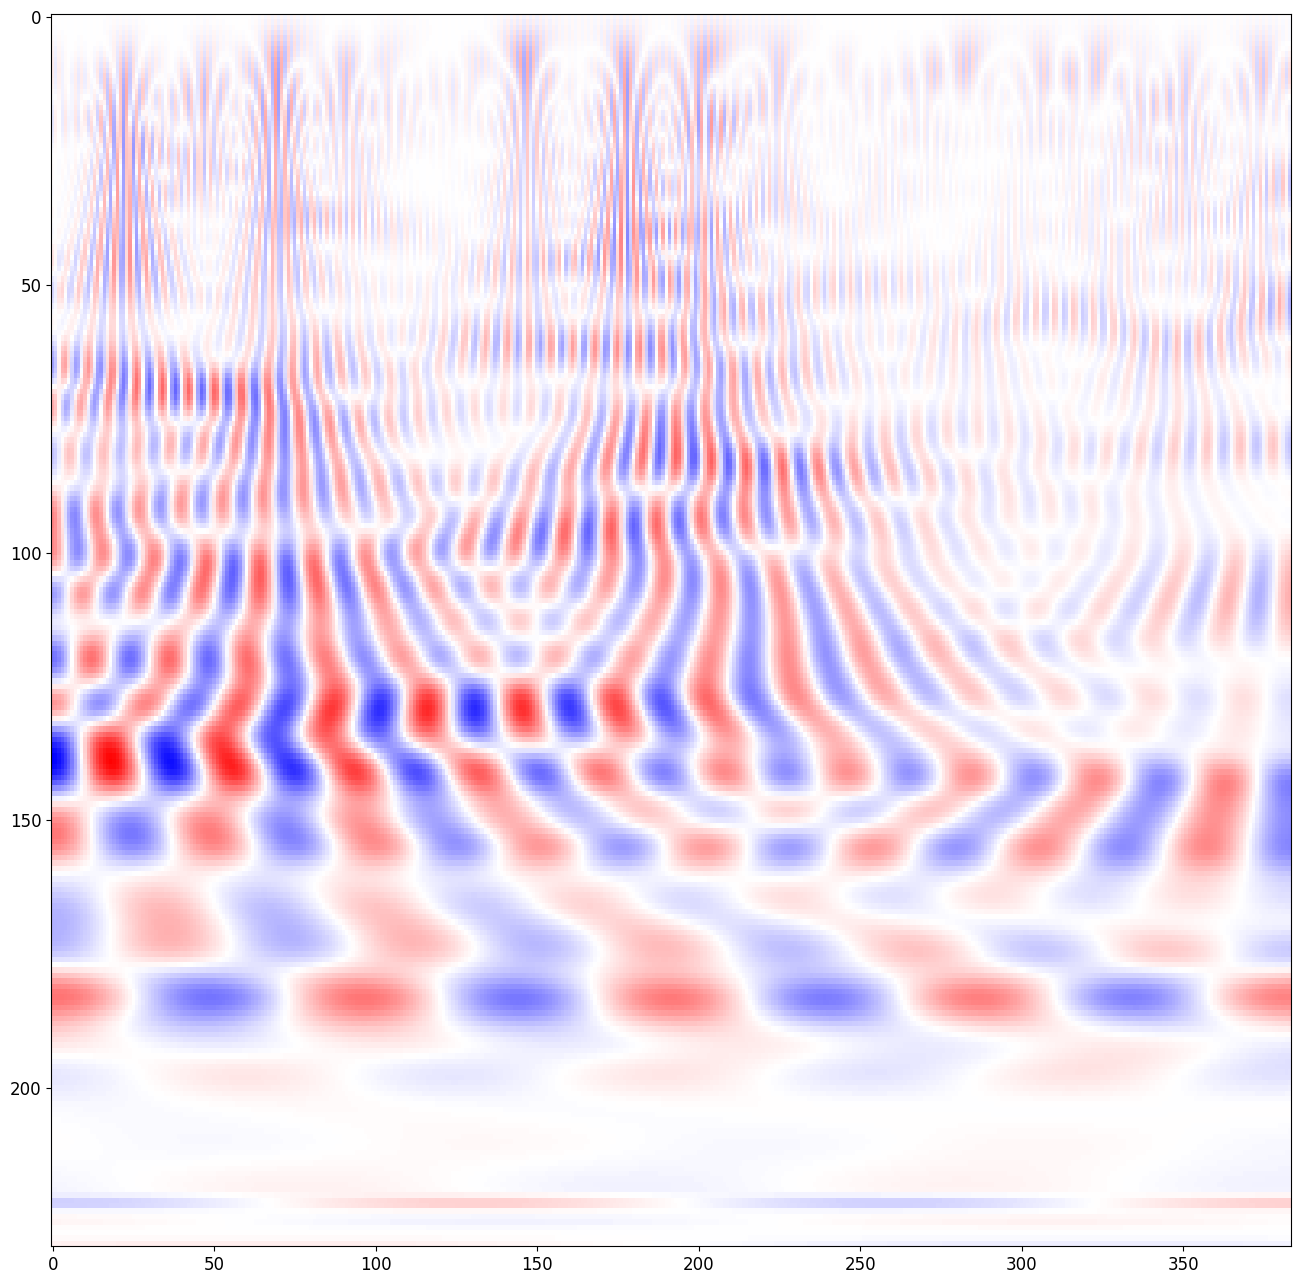

In [11]:
f=plt.figure(figsize=(16, 16))
ax = f.add_subplot()
imshow(Wx[0])
# f.savefig("result.png")

We can now save images of a time chunck of a groups data as an image into folder 'Understood' and 'Not Understood'

In [12]:
%%capture
path = Path('understood?')
if not os.path.exists(path):
        os.makedirs(path)
for grp_num in grp_keys:
    grp = groups.get_group(grp_num).drop(['subject_id','video_id'],axis=1)
    label=int(grp['subject_understood'].unique())
    grp=grp.drop('subject_understood',axis=1)
    data=convertDF2MNE(grp)
    for c,x in enumerate(data):#loop trials
        Wx, scales = cwt(x, 'morlet')
        Wx=np.abs(Wx)
        if label == 0:
            img_path = path/"not-understood"
        else: 
            img_path = path/"understood"
        if not os.path.exists(img_path):
            os.makedirs(img_path)
        img_i_path = img_path/(str(grp_num) + "_" + str(c))
        f=plt.figure(figsize=(8, 4))
        ax = f.add_subplot()
        imshow(Wx[0])
        f.savefig(img_i_path)
        plt.close()
        
        

# Creating the model 

We can now create the model using fastai's library. We first create a Datablock with inputs in as imgaes (ImageBlock) and returns a category as classification (CategoryBlock). We also randomly split 20% of the data into a validation/testing set. We then specify that the label is taken from the parent label of the folder. The batch size is 8. We then show a full batch of images. 

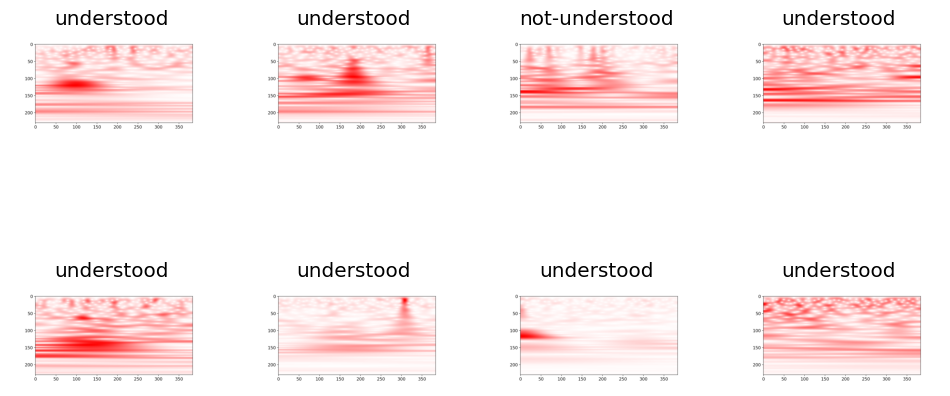

In [13]:

dls = DataBlock(blocks=(ImageBlock, CategoryBlock), get_items = get_image_files, splitter = RandomSplitter(valid_pct=0.2, seed=42), get_y=parent_label).dataloaders(path, bs=8)
dls.show_batch(max_n=8)

Finally to create the model, we use a pretrained resnet34 computer vision model using the 'vision_learner' function with the metric of error_rate. We run this for 8 epochs (including the initialization epoch). Finally we export our model into 'understood_model.pkl'

In [14]:
learn = vision_learner(dls, resnet34, metrics = error_rate)
learn.fit_one_cycle(8)
learn.export('understood_model.pkl')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 214MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.245241,0.678726,0.323529,00:39
1,1.072839,0.646100,0.235294,00:33
2,0.811231,2.536999,0.735294,00:33
3,0.637371,0.493210,0.215686,00:33
4,0.511012,0.517759,0.196078,00:33
5,0.452849,0.567360,0.196078,00:33
6,0.314214,0.471053,0.166667,00:33
7,0.274828,0.411946,0.156863,00:33


Finally we create a Confusion Matrix to show how in which categories our model is failing. 

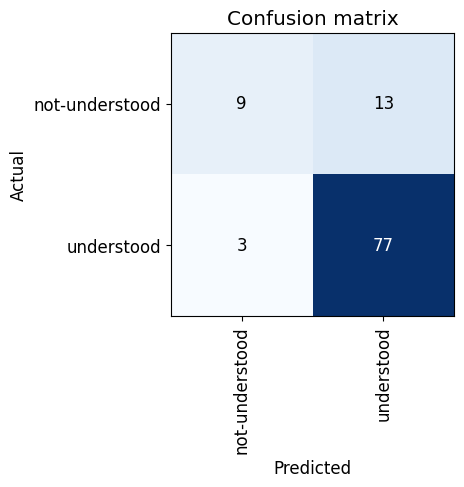

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# 5. Conclusions

This project allowed me to combine what I learnt from the practical deep learning course, what I have learnt in my degree from UofT in Cognitive and Computer Science as well as what I have learnt as a Neurotech Consultant. The high accuracy rate shows that transforming EEG data into images and using this to classify them actually works!